In [17]:
%cd ~/dyna_hash

/impa/home/a/lucas.schwengber/dyna_hash


In [18]:
# all imports
import pathlib
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.lines as mlines
from src.utils.losses import L2
import torch

sns.set_style("darkgrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

benchmarks = ["DPSH", "HashNet", "CEL", "DCH", "DHN", "WGLHH", 
              "HyP2"
             ]
dbs = ["CIFAR_10", "NUS_WIDE", "MS_COCO", "ImageNet"]

## Collect results from main experiment

In [19]:
def norm_features(features, val="col"):
    if val=="col":
            val = np.sqrt(features.shape[-1])
    return features / np.linalg.norm(features, axis=1)[:, np.newaxis] * val

def get_quantization_error(dir, datafolds=["val", "query"]):

    model_dir = pathlib.Path(str(dir).replace("eval","models"))
    l2_errors = {}

    for datafold in datafolds:
        features_path = model_dir / f"{datafold}-features.npy" 
        features = norm_features(np.load(features_path), val = "col")
        l2_errors[datafold] = L2()(torch.tensor(features), None).item()

    return l2_errors

In [ ]:
# load raw data
results = []
for db in dbs:
    BENCH_EVAL_DIR = pathlib.Path(f"/impa/home/a/lucas.resende/dyna_hash/eval/QS/{db}/rotation_experiment")
    ROT_EVAL_DIR = pathlib.Path(f"/impa/home/a/lucas.resende/dyna_hash/eval/HHNN/{db}/rotation_experiment")
    ITQ_EVAL_DIR = pathlib.Path(f"/impa/home/a/lucas.resende/dyna_hash/eval/ITQ/{db}/rotation_experiment")
    ADSH_EVAL_DIR = pathlib.Path(f"/impa/home/a/lucas.resende/dyna_hash/eval/ADSH/{db}/rotation_experiment")

    for d in tqdm(ADSH_EVAL_DIR.glob("*")):
        if ( d / f"val-prediction_mAP.json" ).exists():
            nbits = int(d.name.split("-nbits=")[-1].split("-")[0])
            seed = int(d.name.split("-seed=")[-1].split("-")[0])
            arch = d.name.split("-arch=")[-1].split("-")[0]
            results.append(
                {"db": db, "loss": "ADSH", "nbits": nbits,
                 "r_loss": '-', "seed": seed, "arch": arch, "penalty": '-',
                 "L2_penalty": '-', "HSWD_penalty": '-', "no_cube": '-'
                }
            )
            for fold in ["val", "query"]:
                exp_results = json.load(open( d / f"{fold}-prediction_mAP.json", "r" ))
                for metric in ["mAP_at_k=1000", "mAP_at_k=5000"]:
                    results[-1][f"{fold}_{metric}"] = exp_results[metric]*100

    for EVAL_DIR in [BENCH_EVAL_DIR, ROT_EVAL_DIR, ITQ_EVAL_DIR]:
        for d in tqdm(EVAL_DIR.glob("*")):
            loss = d.name.split("-loss=")[-1].split("-")[0]
            penalty = d.name.split("-penalty=")[-1].split("-")[0]
            pass_HyP2 = True
            if loss == "HyP2":
                pass_HyP2 = (penalty == "1.25" and db != "NUS_WIDE") or (penalty == "0.75" and db == "NUS_WIDE")
            if ( d / f"val-prediction_mAP.json" ).exists() and loss in benchmarks and pass_HyP2:
                nbits = int(d.name.split("-nbits=")[-1].split("-")[0])
                seed = int(d.name.split("-seed=")[-1].split("-")[0])
                arch = d.name.split("-arch=")[-1].split("-")[0]
                L2_penalty = "L2_penalty" in d.name
                HSWD_penalty = "HSWD_penalty" in d.name
                L2_penalty = L2_penalty and not HSWD_penalty
                no_cube = "no_cube" in d.name

                r_loss = "-"
                if "r_loss" in d.name:
                    r_loss = d.name.split("-r_loss=")[-1].split("-")[0]
                if EVAL_DIR == ITQ_EVAL_DIR:
                    r_loss = "ITQ"

                l2_errors = get_quantization_error(d)

                results.append(
                    {"db": db, "loss": loss, "nbits": nbits,
                     "r_loss": r_loss, "seed": seed, "arch": arch, "penalty": penalty,
                     "L2_penalty": L2_penalty, "HSWD_penalty": HSWD_penalty, "no_cube": no_cube,
                     "val_l2_qe":l2_errors["val"] ,"query_l2_qe": l2_errors["query"]
                    }
                )

                for fold in ["val", "query"]:
                    exp_results = json.load(open( d / f"{fold}-prediction_mAP.json", "r" ))
                    for metric in ["mAP_at_k=1000", "mAP_at_k=5000"]:
                        results[-1][f"{fold}_{metric}"] = exp_results[metric]*100

raw_results = pd.DataFrame(results)

In [21]:
# define mAP at k using k=1000 to imagenet and k=5000 to other databases
raw_results["val_mAP"] = raw_results["val_mAP_at_k=1000"]*(raw_results.db == "ImageNet") + raw_results["val_mAP_at_k=5000"]*(raw_results.db != "ImageNet")
raw_results["query_mAP"] = raw_results["query_mAP_at_k=1000"]*(raw_results.db == "ImageNet") + raw_results["query_mAP_at_k=5000"]*(raw_results.db != "ImageNet")
del raw_results["val_mAP_at_k=1000"]
del raw_results["val_mAP_at_k=5000"]
del raw_results["query_mAP_at_k=1000"]
del raw_results["query_mAP_at_k=5000"]

#average over seeds with all other parameters fixed
fixed_cols = ["db","loss","nbits","r_loss","arch","penalty","L2_penalty","HSWD_penalty","no_cube"]
raw_results = raw_results.groupby(fixed_cols).agg({"val_l2_qe":['mean','std'],"query_l2_qe":['mean','std'],'val_mAP':['mean','std'], 'query_mAP':['mean','std']}).reset_index()
raw_results.columns = fixed_cols + ["val_l2_qe", "val_l2_qe_std", "query_l2_qe", "query_l2_qe_std", "val_mAP", "val_mAP_std", "query_mAP", "query_mAP_std"]

In [22]:
# get the right experimental configuration from the parameters
def get_configuration(row):
    if row["loss"] == "ADSH":
        return "ADSH"
    elif row["loss"] == "HashNet":
        if row["r_loss"] == "-":
            return "continuation"
        else:
            return "-"
    elif row["HSWD_penalty"]:
        return "HSWD"
    elif row["r_loss"] == "ITQ":
        return "l0+ITQ"
    elif row["r_loss"] in ["L2", "L1", "bit_var_loss", "min_entry"]:
        return "l0+H2Q+"+row["r_loss"]
    else:
        has_penalty = row["L2_penalty"] or ( row["loss"] not in ["HyP2", "CEL"] and row["penalty"] != "0.0" )
        if has_penalty:
            return "l>0"
        else:
            return "l0"
raw_results["strategy"] = raw_results.apply(lambda row: get_configuration(row), axis=1)

# delete the parameters that are now incorporated in the configuration
del raw_results["no_cube"]
del raw_results["r_loss"]
del raw_results["L2_penalty"]
del raw_results["HSWD_penalty"]

In [ ]:
# get best penalizations on the l>0 strategy
lg0 = raw_results[raw_results.strategy == "l>0"]
lg0 = lg0.loc[lg0.groupby(["db", "loss", "nbits", "arch", "strategy"])['val_mAP'].idxmax()][["db", "loss", "nbits", "arch","query_l2_qe", "query_l2_qe_std", "query_mAP", "query_mAP_std", "strategy"]]

# join with the rest of the data
non_lg0 = raw_results[raw_results.strategy != "l>0"]
del non_lg0["penalty"]
del non_lg0["val_mAP"]
del non_lg0["val_mAP_std"]
del non_lg0["val_l2_qe"]
del non_lg0["val_l2_qe_std"]

# use DHN to fill DPSH on the non_l>0 case
# since they have the same similarity loss
non_lg0 = non_lg0[ non_lg0.loss != "DPSH" ]
non_lg0_DPSH = non_lg0[ non_lg0.loss == "DHN" ].copy()
non_lg0_DPSH["loss"] = "DPSH"

results = pd.concat([lg0, non_lg0_DPSH, non_lg0])
results

In [24]:
# compare strategies
def stack_strategies(df, sts):
    dfs = []
    for st in sts:
        df_st = df[ df.strategy == st ].copy()
        df_st[f"{st}_mAP"] = df_st["query_mAP"]
        df_st[f"{st}_l2_qe"] = df_st["query_l2_qe"]
        del df_st["query_mAP"]
        del df_st["query_mAP_std"] # need to fix
        del df_st["query_l2_qe"]
        del df_st["query_l2_qe_std"]
        del df_st["strategy"]
        dfs.append(df_st)
    df_final = dfs[0]
    for df_st in dfs[1:]:
        df_final = pd.merge(df_final, df_st, on=["db", "nbits", "loss", "arch"])

    for st in sts:
        if st != "l0":
            df_final[f"delta_{st}"] = df_final[f"{st}_mAP"] - df_final["l0_mAP"]

    df_final["winner"] = df_final.apply(lambda row: sts[np.argmax([row[f"{st}_mAP"] for st in sts])], axis = 1)
    return df_final


strategies_to_compare = ["l0", 
                        "HSWD", 
                        "l0+H2Q+L2", 
                        "l0+H2Q+L1", 
                        "l0+H2Q+min_entry", 
                        "l0+H2Q+bit_var_loss", 
                        "l0+ITQ",
                        "l>0"
                        ]

strategy_comparisons = stack_strategies(results, strategies_to_compare)

In [30]:
arch = "CNNF_alexnet"

filtered_df = strategy_comparisons[(strategy_comparisons.arch == arch)]

dbs = ["CIFAR_10", "NUS_WIDE", "MS_COCO", "ImageNet"]

dbs_s = ["CIFAR 10", "NUS WIDE", "MS COCO", "ImageNet"]

losses_pallette = {"DPSH" : "blue", "CEL": "orange", "DCH": "black", "WGLHH": "green", "HyP2": "brown"}

In [ ]:
for strat in [
"l>0", 
"l0+H2Q+L2", 
"l0+ITQ", 
"l0+H2Q+L1", 
"l0+H2Q+min_entry", 
"l0+H2Q+bit_var_loss", 
"HSWD"
]:
    avg_delta_pos = (filtered_df[f"delta_{strat}"]>0).mean()
    avg_delta = filtered_df[f"delta_{strat}"].mean()
    avg_winner = (filtered_df["winner"]==f"{strat}").mean()
    max_delta = filtered_df[f"delta_{strat}"].max()
    print(f"avg_(delta_{strat})>0={avg_delta_pos}")
    print(f"avg_delta_{strat}={avg_delta}")
    print(f"avg_win={avg_winner}")
    print(f"max_delta={max_delta}")

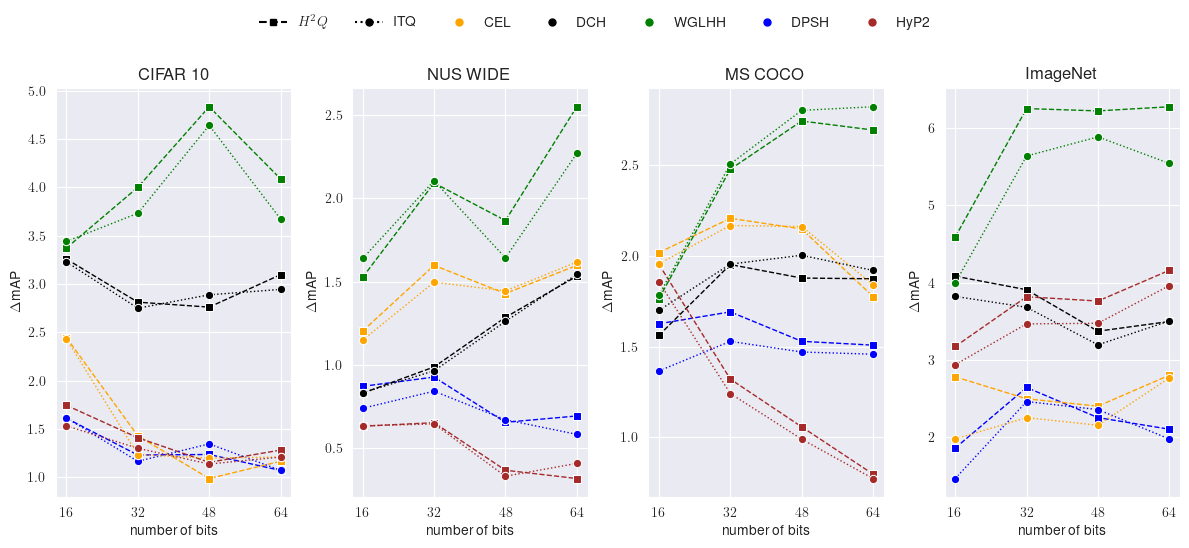

In [10]:
losses = ["CEL",
          "DCH",
          "WGLHH",
          "DPSH",
          "HyP2"
          ]

opts = ["H2Q+L2","ITQ"]
ms = {"H2Q+L2":'s', "ITQ":'o', "H2Q+min_entry":'v'}
ls = {"H2Q+L2":'--', "ITQ":'dotted', "H2Q+min_entry":'dashdot'}

data = strategy_comparisons[(strategy_comparisons.arch == arch) & (strategy_comparisons.loss.isin(losses))]

plt.rcParams["figure.figsize"] = (12,5)

for i, db in enumerate(dbs):
    
    db_data = data[data["db"]==db]

    plt.subplot(1,4,i+1)

    for opt in opts:
        sns.lineplot(
            db_data,
            x="nbits", y=f"delta_l0+{opt}", hue="loss", legend=False,
            palette=losses_pallette,
            linestyle=ls[opt],
            marker=ms[opt],
            lw=1
        )

    plt.xlabel(r"number of bits")
    plt.ylabel(r"$\Delta$mAP")
    plt.title(dbs_s[i])
    plt.xticks([16,32,48,64])

handles = [
    mlines.Line2D([], [], color='black', marker='s', linestyle='--', markersize=5),
    mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', markersize=5),
    #mlines.Line2D([], [], color='black', marker='v', linestyle='dashdot', markersize=5),
] + [mlines.Line2D([], [], color=losses_pallette[loss], marker='o', linestyle='None', markersize=5)
     for loss in losses]

plt.figlegend(handles, [r"$H^2Q$", "ITQ"] + losses, loc = 'upper center', ncol=9, frameon=False, bbox_to_anchor=(0.5, 1.10))

plt.tight_layout()
plt.savefig(f"notebooks/figures/itq_h2q_{arch}_all_dbs_map_l2.pdf", bbox_inches='tight')

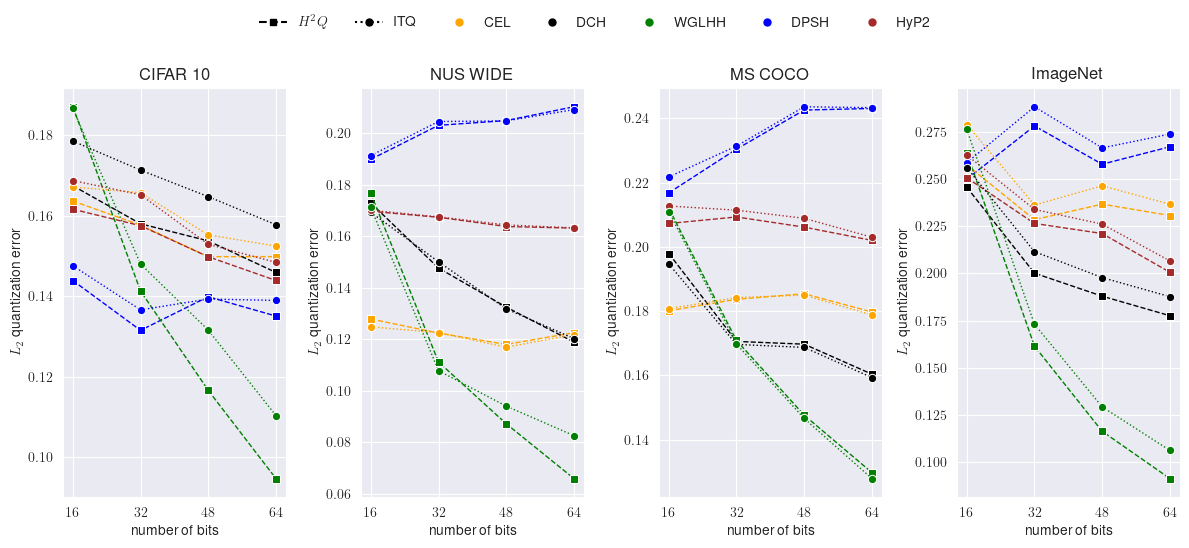

In [11]:
plt.rcParams["figure.figsize"] = (12,5)

for i, db in enumerate(dbs):
    
    db_data = data[data["db"]==db]

    plt.subplot(1,4,i+1)

    opts = ["H2Q+L2", "ITQ"]

    for opt in opts:
        sns.lineplot(
            db_data,
            x="nbits", y=f"l0+{opt}_l2_qe", hue="loss", legend=False,
            palette=losses_pallette,
            linestyle=ls[opt],
            marker=ms[opt],
            lw=1
        )

    plt.xlabel(r"number of bits")
    plt.ylabel(r"$L_2$ quantization error")
    #plt.ylim(0.06,0.3)
    plt.title(dbs_s[i])
    plt.xticks([16,32,48,64])

handles = [
    mlines.Line2D([], [], color='black', marker='s', linestyle='--', markersize=5),
    mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', markersize=5),
    #mlines.Line2D([], [], color='black', marker='v', linestyle='dashdot', markersize=5)
] + [mlines.Line2D([], [], color=losses_pallette[loss], marker='o', linestyle='None', markersize=5)
     for loss in losses if loss in losses]


plt.figlegend(handles, [r"$H^2Q$", "ITQ"] + losses, loc = 'upper center', ncol=9, frameon=False, bbox_to_anchor=(0.5, 1.10))

plt.tight_layout()
plt.savefig(f"notebooks/figures/itq_h2q_{arch}_all_dbs_l2_qe.pdf", bbox_inches='tight')

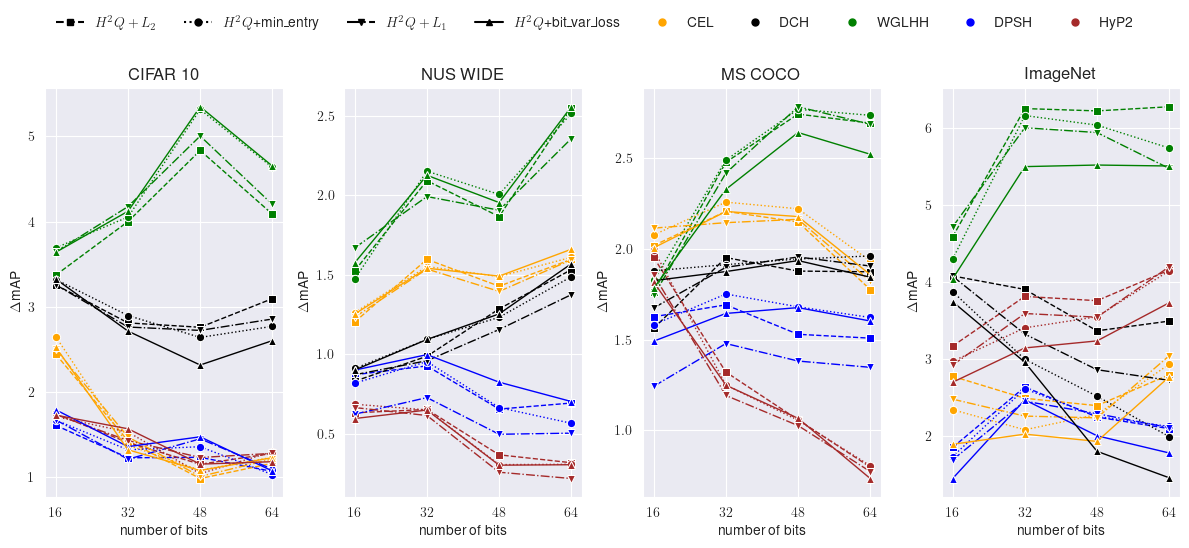

In [12]:
opts = ["H2Q+L2","H2Q+min_entry","H2Q+L1","H2Q+bit_var_loss"]
ms = {"H2Q+L2":'s', "H2Q+min_entry":'o', "H2Q+L1":'v', "H2Q+bit_var_loss":"^"}
ls = {"H2Q+L2":'--', "H2Q+min_entry":'dotted', "H2Q+L1":'dashdot', "H2Q+bit_var_loss":"solid"}

data = strategy_comparisons[(strategy_comparisons.arch == arch) & (strategy_comparisons.loss.isin(losses))]

plt.rcParams["figure.figsize"] = (12,5)

for i, db in enumerate(dbs):
    
    db_data = data[data["db"]==db]

    plt.subplot(1,4,i+1)

    for opt in opts:
        sns.lineplot(
            db_data,
            x="nbits", y=f"delta_l0+{opt}", hue="loss", legend=False,
            palette=losses_pallette,
            linestyle=ls[opt],
            marker=ms[opt],
            lw=1
        )

    plt.xlabel(r"number of bits")
    plt.ylabel(r"$\Delta$mAP")
    plt.title(dbs_s[i])
    plt.xticks([16,32,48,64])

handles = [
    mlines.Line2D([], [], color='black', marker='s', linestyle='--', markersize=5),
    mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', markersize=5),
    mlines.Line2D([], [], color='black', marker='v', linestyle='dashdot', markersize=5),
    mlines.Line2D([], [], color='black', marker='^', linestyle='solid', markersize=5),
] + [mlines.Line2D([], [], color=losses_pallette[loss], marker='o', linestyle='None', markersize=5)
     for loss in losses]

plt.figlegend(handles, [r"$H^2Q+L_2$", r"$H^2Q$+min_entry", r"$H^2Q+L_1$", r"$H^2Q$+bit_var_loss"] + losses, loc = 'upper center', ncol=9, frameon=False, bbox_to_anchor=(0.5, 1.10))

plt.tight_layout()
plt.savefig(f"notebooks/comparisons/h2q_losses_{arch}_all_dbs_map_l2.pdf", bbox_inches='tight')

In [13]:
# table utils
def get_lines(
        df,
        loss,
        arch,
        strategies,
        nbs=[16, 32, 48, 64],
        dbs=["CIFAR_10", "NUS_WIDE", "MS_COCO", "ImageNet"],
        with_std = False
):
    df_filtered = df[(df.loss == loss) & (df.strategy.isin(strategies)) & (df.arch == arch) & (df.nbits.isin(nbs)) & (df.db.isin(dbs))]
    lines = []
    for strategy in strategies:
        line = []
        for db in dbs:
            for nb in nbs:
                v = df_filtered.query_mAP[(df_filtered.db == db)&(df_filtered.strategy == strategy)&(df_filtered.nbits == nb)].values[0]
                if with_std:
                    s = df_filtered.query_mAP_std[(df_filtered.db == db)&(df_filtered.strategy == strategy)&(df_filtered.nbits == nb)].values[0]
                    line.append((v,s))
                else:
                    line.append(v)
        lines.append(line)

    return lines

def print_table_head(no_skip=False):
    print("\\begin{table*}[]\\centering")
    if no_skip:
        print("\\begin{tabular}{l@{\\hskip .01in}|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c}")
    else:
        print("\\begin{tabular}{l|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c}")
    print("& \\multicolumn{4}{c|}{CIFAR 10} & \\multicolumn{4}{c|}{NUS WIDE} & \\multicolumn{4}{c|}{MS COCO} & \\multicolumn{4}{c}{ImageNet} \\\\ \\hline")
    print("n bits & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64\\\\ \\hline")

def print_table_footer(caption, label):
    print("\\end{tabular}")
    print("\\caption{"+caption+".}")
    print("\\label{tab:"+label+"}")
    print("\\end{table*}")

def format_lines(lines, loss_label, strategy_labels, underline=False, color_bad=False, put_separation=True):
    has_std = False
    if isinstance(lines[0][0], tuple):
        has_std = True
        lines_only_avg = [ [ v for (v,_) in line ] for line in lines]
    else:
        lines_only_avg = lines

    best_lines = np.argmax(lines_only_avg, axis=0)
    non_improv_lines = np.array(lines_only_avg) - np.array(lines_only_avg[0])[None, :] < 0

    for i, (line, strategy_label) in enumerate(zip(lines, strategy_labels)):
        if has_std:
            str_line = "{" + f"\\footnotesize {loss_label}{strategy_label}" + "}"
        else:
            str_line = f"{loss_label}{strategy_label}"
        for j, v in enumerate(line):
            if has_std:
                str_value = "{\\footnotesize" + f"{v[0]:.1f}$^" + "{" + f"{v[1]:.1f}" + "}$}"
            else:
                str_value = f"{v:.1f}" 
            if underline and i == best_lines[j]:
                str_value = "\\textbf{" + str_value + "}"
            if color_bad and non_improv_lines[i][j]:
                str_value = "{\\color{red}" + str_value + "}"
            str_line += " & "+str_value
        if i == len(strategy_labels) - 1 and put_separation:
            print(str_line + "\\\\[.5em]")
        else:
            print(str_line + "\\\\")


In [14]:
# make single table that compares our method with the sota and no quantization
for arch in ["CNNF_alexnet", "CNNF_vgg16"]:
    print_table_head()
    format_lines(get_lines(results, "ADSH", arch=arch, strategies=["ADSH"]), "ADSH", strategy_labels=[""], put_separation=True)
    format_lines(get_lines(results, "HashNet", arch=arch, strategies=["continuation"]), "HashNet", strategy_labels=[""], put_separation=True)
    format_lines(get_lines(results, "CEL", arch=arch, strategies=["l0", "l>0", "HSWD", "l0+H2Q+L2"]), "CEL", strategy_labels=[" ($\\lambda=0$)", " + $\\lambda$", " + HSWD", " + H²Q"], put_separation=True, underline=True, color_bad=True)
    format_lines(get_lines(results, "DCH", arch=arch, strategies=["l0", "l>0", "HSWD", "l0+H2Q+L2"]), "DCH", strategy_labels=[" ($\\lambda=0$)", " + $\\lambda$"," + HSWD", " + H²Q"], put_separation=True, underline=True, color_bad=True)
    format_lines(get_lines(results, "DHN", arch=arch, strategies=["l0", "l>0", "HSWD", "l0+H2Q+L2"]), "DHN", strategy_labels=[" ($\\lambda=0$)", " + $\\lambda$"," + HSWD", " + H²Q"], put_separation=True, underline=True, color_bad=True)
    format_lines(get_lines(results, "DPSH", arch=arch, strategies=["l0", "l>0", "HSWD", "l0+H2Q+L2"]), "DPSH", strategy_labels=[" ($\\lambda=0$)", " + $\\lambda$"," + HSWD", " + H²Q"], put_separation=True, underline=True, color_bad=True)
    format_lines(get_lines(results, "WGLHH", arch=arch, strategies=["l0", "l>0", "HSWD", "l0+H2Q+L2"]), "WGLHH", strategy_labels=[" ($\\lambda=0$)", " + $\\lambda$"," + HSWD", " + H²Q"], put_separation=True, underline=True, color_bad=True)
    format_lines(get_lines(results, "HyP2", arch=arch, strategies=["l0", "l>0", "HSWD", "l0+H2Q+L2"]), "HyP²", strategy_labels=[" ($\\lambda=0$)", " + $\\lambda$"," + HSWD", " + H²Q"], put_separation=True, underline=True, color_bad=True)
  
    print_table_footer("\\texttt{mAP@k} with "+arch[5:], f"sota_{arch}")

\begin{table*}[]\centering
\begin{tabular}{l|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c}
& \multicolumn{4}{c|}{CIFAR 10} & \multicolumn{4}{c|}{NUS WIDE} & \multicolumn{4}{c|}{MS COCO} & \multicolumn{4}{c}{ImageNet} \\ \hline
n bits & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64\\ \hline
ADSH & 56.7 & 71.8 & 77.3 & 79.7 & 74.8 & 78.4 & 79.8 & 80.3 & 57.9 & 61.1 & 63.7 & 65.0 & 5.2 & 8.3 & 13.4 & 23.2\\[.5em]
HashNet & 80.8 & 82.1 & 82.3 & 82.3 & 79.8 & 81.5 & 82.2 & 82.7 & 62.9 & 67.3 & 68.2 & 70.2 & 41.2 & 54.3 & 58.8 & 62.5\\[.5em]
CEL ($\lambda=0$) & 79.8 & 81.0 & 81.7 & 81.3 & 79.4 & 80.3 & 80.7 & 80.7 & 64.4 & 66.3 & 67.5 & 68.4 & 51.8 & 52.5 & 53.7 & 45.6\\
CEL + $\lambda$ & 80.2 & {\color{red}79.1} & {\color{red}77.8} & {\color{red}70.7} & {\color{red}79.2} & {\color{red}79.8} & {\color{red}79

In [15]:
# make big table for the SM
sts = ["l0", "l0+ITQ", "l>0", "HSWD", "l0+H2Q+L2", "l0+H2Q+L1", "l0+H2Q+min_entry", "l0+H2Q+bit_var_loss"]
st_labels = ["($\\lambda=0$)", "+ITQ", "+$\\lambda$", "+HSWD", "+H²Q($L_2$)",  "+H²Q($L_1$)", "+H²Q(min)", "+H²Q(bit)" ]
for arch in ["CNNF_alexnet", "CNNF_vgg16"]:
    print_table_head(no_skip=True)
    format_lines(get_lines(results, "ADSH", arch=arch, strategies=["ADSH"], with_std=True), "ADSH", strategy_labels=[""])
    format_lines(get_lines(results, "HashNet", arch=arch, strategies=["continuation"], with_std=True), "HashNet", strategy_labels=[""])
    format_lines(get_lines(results, "CEL", arch=arch, strategies=sts, with_std=True), "CEL", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "DCH", arch=arch, strategies=sts, with_std=True), "DCH", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "DHN", arch=arch, strategies=sts, with_std=True), "DHN", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "DPSH", arch=arch, strategies=sts, with_std=True), "DPSH", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "WGLHH", arch=arch, strategies=sts, with_std=True), "WGL.", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "HyP2", arch=arch, strategies=sts, with_std=True), "HyP²", strategy_labels=st_labels, underline=True, color_bad=True)
    print_table_footer("\\texttt{mAP@k} with "+arch[5:], f"improve_{arch}")

\begin{table*}[]\centering
\begin{tabular}{l@{\hskip .01in}|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c}
& \multicolumn{4}{c|}{CIFAR 10} & \multicolumn{4}{c|}{NUS WIDE} & \multicolumn{4}{c|}{MS COCO} & \multicolumn{4}{c}{ImageNet} \\ \hline
n bits & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64\\ \hline
{\footnotesize ADSH} & {\footnotesize56.7$^{0.6}$} & {\footnotesize71.8$^{0.6}$} & {\footnotesize77.3$^{0.3}$} & {\footnotesize79.7$^{0.5}$} & {\footnotesize74.8$^{0.5}$} & {\footnotesize78.4$^{0.3}$} & {\footnotesize79.8$^{0.2}$} & {\footnotesize80.3$^{0.2}$} & {\footnotesize57.9$^{0.3}$} & {\footnotesize61.1$^{0.3}$} & {\footnotesize63.7$^{0.5}$} & {\footnotesize65.0$^{0.1}$} & {\footnotesize5.2$^{0.3}$} & {\footnotesize8.3$^{0.4}$} & {\footnotesize13.4$^{0.2}$} & {\footnotesize23.2$^{0.3}$}\\[.5em]


In [ ]:
def process_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    data = []
    group = 0
    i = 0
    while i < len(lines)-1:
        if group % 4 == 0:
            # train + penalty
            name = lines[i].split('\n')[0]
            seed = int(lines[i + 1].split(': ')[1])
            nbits = int(lines[i + 2].split(': ')[1])
            start = int(lines[i + 3].split(': ')[1])
            for j in range(4):
                finish = int(lines[i + 4 + j].split(': ')[1])
                data.append([f"training {j+1} lambdas", seed, nbits, start, finish])
            i += 9
        else:
            name = lines[i].split('\n')[0]
            seed = int(lines[i + 1].split(': ')[1])
            nbits = int(lines[i + 2].split(': ')[1])
            start = int(lines[i + 3].split(': ')[1])
            finish = int(lines[i + 4].split(': ')[1])
            data.append([name, seed, nbits, start, finish])
            i += 5
        group += 1

    df = pd.DataFrame(data, columns=['strategy', 'seed', 'nbits', 'start', 'finish'])
    return df


df = process_file('time_experiment.txt')
df["delta"] = df["finish"] - df["start"]
df

In [ ]:
# merge strategies
def merge_strategies(df, st1, st2, new_label):
    df1 = df[df["strategy"] == st1]
    df2 = df[df["strategy"] == st2]
    joined = df1.join(df2.set_index(["seed", "nbits"]), on=["seed", "nbits"], lsuffix="_")
    joined["delta"] += joined["delta_"]
    joined = joined.drop(columns=["strategy_", "delta_"])
    joined["strategy"] = new_label
    return joined

df_organized = pd.concat([
    merge_strategies(df, "training 1 lambdas", "predicting + penalty", "One penalization"),
    merge_strategies(df, "training 2 lambdas", "predicting + penalty", "Two penalizations"),
    merge_strategies(df, "training 3 lambdas", "predicting + penalty", "Three penalizations"),
    merge_strategies(df, "training 4 lambdas", "predicting + penalty", "Four penalizations"),
    merge_strategies(df, "training + H2Q", "prediction + H2Q", "H2Q"),
])
df_organized.delta /= 60

c_palette = {
    "One penalization": "#ff9999",  # Light red
    "Two penalizations": "#ff6666",  # Medium red
    "Three penalizations": "#ff3333",  # Darker red
    "Four penalizations": "#cc0000",  # Deep red
    "H2Q": "C0"   # Pure red
}

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
sns.boxplot(df_organized, ax=ax, x = "nbits", y="delta", hue="strategy", palette=c_palette)
plt.yscale("log")
plt.xlabel("Number of bits")
plt.ylabel("Time (min)")
handles, _ = ax.get_legend_handles_labels()
labels = [r"$1\lambda$", r"$2\lambda s$", r"$3\lambda s$", r"$4\lambda s$", "H2Q"]
plt.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor = (0, .15, 1, 1), frameon=False)
plt.tight_layout()

plt.savefig("time_experiment.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()